In [3]:
import csv
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from copy import deepcopy
from scipy.spatial.distance import cdist

In [3]:
#File1 - Participant Data
AppParticipationFields = ['LUID', 'Date', 'Hour', 'Instances']

AppParticipation = [] #Array of dictionary having List of rows in file
intermediate = [] #intermediate array to make numpy
with open('AppParticipation_year2.csv', 'r') as f:
    csv_f = csv.reader(f)
    fields = next(csv_f)
    mylist = list(csv_f)
for i in range(0, len(mylist)):
    string = mylist[i]
    values = string[0].split('\t')
    # intermediate.append(values)
    AppParticipation.append({AppParticipationFields[j]:values[j] for j in range(0,len(AppParticipationFields))})
#print(AppParticipation)

In [4]:
#File2 - Location Data
LocationFields = ['LUID', 'Date', 'Latitude', 'Longitude', 'Floor', 'BuildingID', 'Time']

LocationData = [] #Array of dictionary having List of rows in file
with open('EstIndoorLocation_year2.csv', 'r') as f1:
    csv_f1 = csv.reader(f1)
    fields1 = next(csv_f1)
    mylist1 = list(csv_f1)
for i in range(0, len(mylist1)):
    string1 = mylist1[i]
    values = string1[0].split('\t')
    datetime = values[1].split(" ")
    date = datetime[0]
    time = datetime[1]
    values[1] = date
    values.append(time)
    LocationData.append({LocationFields[j]:values[j] for j in range(0,len(LocationFields))})

In [5]:
# threshhold = 10 #threshhold for minimum number of instances
#What is happening - If the minimum threshold is not met in the Participation array, remove the user from the Location array
i=0
j=0
count = len(LocationData)-1

while i<len(LocationData):
    while j<len(AppParticipation):
        if(AppParticipation[j]["LUID"] == LocationData[i]["LUID"] and (int(AppParticipation[j]["Instances"]))<10):
            # print(AppParticipation[j])
            count=count-1
            del LocationData[i]
        j=j+1
    i=i+1

# #Writing final data to csv file
os.remove("fulldatetime.csv")
csv_file = "fulldatetime.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=LocationFields)
        writer.writeheader()
        for data in LocationData:
            writer.writerow(data)
except IOError:
    print("I/O error")

In [4]:
#reading data into data
data = pd.read_csv('fulldatetime.csv')
print("Input data and shape")
print(type(data))
data.head()
data.shape

Input data and shape
<class 'pandas.core.frame.DataFrame'>


(576574, 7)

In [32]:
print(max(data['Latitude']))
print(min(data['Latitude']))
print(max(data['Longitude']))
print(min(data['Longitude']))
print(type(data['Latitude']))
print(type(data['Longitude']))

38.99287800000001
0.0
0.0
-76.94402585367764
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [7]:
#Checking if any data is empty
data[pd.isnull(data).any(axis=1)]

,LUID,Date,Latitude,Longitude,Floor,BuildingID,Time


In [9]:
date = ['2018-02-09']
week = data[data.Date.isin(date)]
week.shape
print(week['Latitude'])
print(" ")
print(week['Longitude'])

53        38.992558
54        38.992558
55        38.992558
56        38.992558
57        38.992787
58        38.992787
59        38.992844
60        38.992844
61        38.992844
62        38.992844
63        38.992844
64        38.992844
65        38.992844
11514     38.991985
11515     38.991985
11516     38.991985
11517     38.991985
11518     38.991985
11519     38.991985
11520     38.991985
11521     38.991985
11522     38.991985
11523     38.991985
11524     38.991985
11525     38.991985
11526     38.991985
11527     38.991985
11528     38.991985
11529     38.991985
11530     38.991985
            ...    
502739    38.990357
502740    38.990357
502741    38.990361
502742    38.990369
502743    38.990369
502744    38.990369
502745    38.990369
502746    38.990372
502747    38.990372
502748    38.990374
502749    38.990358
502750    38.990371
502751    38.990371
502752    38.990371
502753    38.990371
502754    38.990371
502755    38.990372
502756    38.990372
502757    38.990372


In [8]:
#taking only a week's inputs - 09/02/18-15/02/18
date = ['2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15']
week = data[data.Date.isin(date)]
week.shape

(46252, 7)

In [9]:
#2 features on which clustering should happen
f1 = week['Date'].values
f2 = week['Time'].values
print(type(f2[0]))
print(f2)

<class 'str'>
['20:18:09' '20:17:38' '20:19:08' ... '23:58:32' '23:55:32' '23:58:32']


In [10]:
#Changing the time to ttime in seconds
for i in range(0,len(f2)):
    values = f2[i].split(":")
    timestamp = (int(values[0])*60*60)+(int(values[1])*60)+int(values[2])
    f2[i]=timestamp

In [11]:
### Binning the dates to approxiations or aggregating times to bins
class RangeDict(dict):
    def __getitem__(self, item):
        if type(item) != range: # or xrange in Python 2
            for key in self:
                if item in key:
                    return self[key]
        else:
            return super().__getitem__(item)
        
rangedict = RangeDict({range(0,1800): 1, range(1800,3600): 2, range(3600,5400): 3, range(5400,7200): 4,
                       range(7200,9000): 5, range(9000,10800): 6, range(10800,12600): 7, range(12600,14400): 8,
                       range(14400,16200): 9, range(16200,18000): 10, range(18000,19800): 11, range(19800,21600): 12,
                       range(21600,23400): 13, range(23400,25200): 14, range(25200,27000): 15, range(1800*15,1800*16): 16,
                       range(1800*16,1800*17): 17, range(1800*17,1800*18): 18, range(1800*18,1800*19): 19, range(1800*19,1800*20): 20,
                       range(1800*20,1800*21): 21, range(1800*21,1800*22): 22, range(1800*22,1800*23): 23, range(1800*23,1800*24): 24,
                       range(1800*24,1800*25): 25, range(1800*25,1800*26): 26, range(1800*26,1800*27): 27, range(1800*27,1800*28): 28,
                       range(1800*28,1800*29): 29, range(1800*29,1800*30): 30, range(1800*30,1800*31): 31, range(1800*31,1800*32): 32,
                       range(1800*32,1800*33): 33, range(1800*33,1800*34): 34, range(1800*34,1800*35): 35, range(1800*35,1800*36): 36,
                       range(1800*36,1800*37): 37, range(1800*37,1800*38): 38, range(1800*38,1800*39): 39, range(1800*39,1800*40): 40,
                       range(1800*40,1800*41): 41, range(1800*41,1800*42): 42, range(1800*42,1800*43): 43, range(1800*43,1800*44): 44,
                       range(1800*44,1800*45): 45, range(1800*45,1800*46): 46, range(1800*46,1800*47): 47, range(1800*47,1800*48): 48, range(1800*48,1800*49): 49})
for i in range(0, len(f2)):
    val = rangedict[f2[i]]
    #print(val)
    f2[i]=val

In [12]:
#Binning the dates of the week
for i in range(len(f1)):
    if(f1[i]=='2018-02-09'):
        f1[i]=1
    elif(f1[i]=='2018-02-10'):
        f1[i]=2
    elif(f1[i]=='2018-02-11'):
        f1[i]=3
    elif(f1[i]=='2018-02-12'):
        f1[i]=4
    elif(f1[i]=='2018-02-13'):
        f1[i]=5
    elif(f1[i]=='2018-02-14'):
        f1[i]=6
    elif(f1[i]=='2018-02-15'):
        f1[i]=7

In [13]:
#Writing another file
os.remove("overallnew.csv")
FinalData = "overallnew.csv"
week.to_csv(FinalData, sep=',', encoding='utf-8')

In [14]:
#reading data into data
data = pd.read_csv('overallnew.csv')
print("Input data and shape")
print(type(data))
data.head()
data.shape

Input data and shape
<class 'pandas.core.frame.DataFrame'>


(46252, 8)

In [15]:
#Final data types
data.dtypes

Unnamed: 0      int64
LUID           object
Date            int64
Latitude      float64
Longitude     float64
Floor           int64
BuildingID      int64
Time            int64
dtype: object

In [16]:
#Checking if any data is empty
data[pd.isnull(data).any(axis=1)]

,Unnamed: 0,LUID,Date,Latitude,Longitude,Floor,BuildingID,Time


In [17]:
#2 features on which clustering should happen
f1 = data['Date'].values
f2 = data['Time'].values

In [18]:
#zipping the features
X = np.array(list(zip(f1, f2)))

[[ 5. 43.]
 [ 3. 44.]
 [ 2.  3.]]


Text(0.5,1,'Date vs Time for LUIDs')

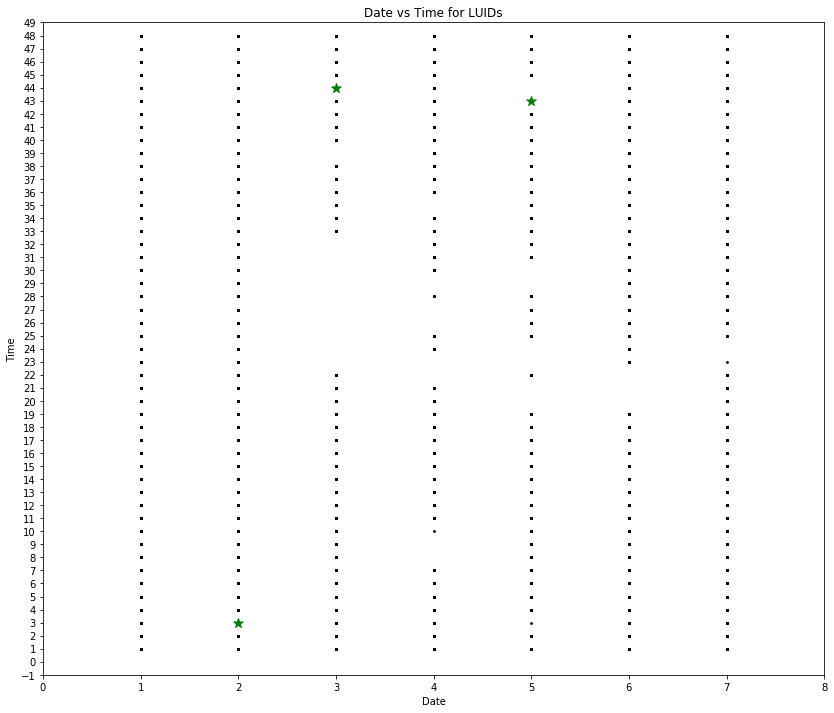

In [19]:
#Number of clusters = 3
k = 3

#Random centroids
C_x = np.random.randint(0, 8, size=k)
C_y = np.random.randint(-1, 49, size=k)

C = np.array(list(zip(C_x, C_y)), dtype = np.float32)
print(C)

#Before clustering, just plotting the points
fig, ax = plt.subplots(figsize=(14, 12))

tick_spacingx = 1
tick_spacingy = 1
ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacingx))
ax.yaxis.set_major_locator(plt.MultipleLocator(tick_spacingy))

plt.scatter(f1, f2, c='#050505', s = 2)
plt.scatter(C_x, C_y, marker='*', s = 100, c='g')
plt.ylim([-1, 49])
plt.xlim([0, 8])
plt.xlabel("Date")
plt.ylabel("Time")
plt.title("Date vs Time for LUIDs")

In [20]:
#Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [21]:
#To store the value of centroids when it updates
C_old = np.zeros(C.shape)

#Cluster Lables(0, 1, 2)
clusters = np.zeros(len(X))

#Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
print(error)

61.90315016216864


In [26]:
#Loop will run till the error becomes zero
while error != 0:
    # Assigning each value to its closest cluster
    for i in range(len(X)):
        distances = dist(X[i], C)
        cluster = np.argmin(distances)
        clusters[i] = cluster
    # Storing the old centroid values
    C_old = deepcopy(C)
    print(C_old)
    # Finding the new centroids by taking the average value
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    error = dist(C, C_old, None)
    print(error)

[[ 2.9515605 27.815649 ]
 [ 4.228308  42.139603 ]
 [ 3.6657186  9.666563 ]]
0.9995878
[[ 2.815196  26.927677 ]
 [ 4.294962  41.892372 ]
 [ 3.7011578  9.312635 ]]
0.40857702
[[ 2.8628042 26.607784 ]
 [ 4.2044463 41.659683 ]
 [ 3.7011578  9.312635 ]]
0.88364977
[[ 2.717362  25.826298 ]
 [ 4.2540126 41.48373  ]
 [ 3.763294   8.978442 ]]
0.6275148
[[ 2.8394487 25.288803 ]
 [ 4.1732206 41.22776  ]
 [ 3.728704   8.849118 ]]
0.5293063
[[ 2.7142618 24.830658 ]
 [ 4.2110987 41.11751  ]
 [ 3.7845166  8.65446  ]]
0.7783314
[[ 2.7823644 24.147451 ]
 [ 4.2372694 40.930027 ]
 [ 3.7353837  8.344394 ]]
0.34568164
[[ 2.8180826 23.872482 ]
 [ 4.172849  40.73391  ]
 [ 3.7353837  8.344394 ]]
0.19326101
[[ 2.7814429 23.713827 ]
 [ 4.172849  40.73391  ]
 [ 3.7704086  8.246367 ]]
0.26524657
[[ 2.738604  23.483303 ]
 [ 4.1925526 40.67304  ]
 [ 3.7882304  8.141639 ]]
0.4825612
[[ 2.7958002 23.068226 ]
 [ 4.212173  40.57008  ]
 [ 3.7465868  7.9304867]]
0.38812643
[[ 2.8597395 22.742882 ]
 [ 4.1709023 40.38583  

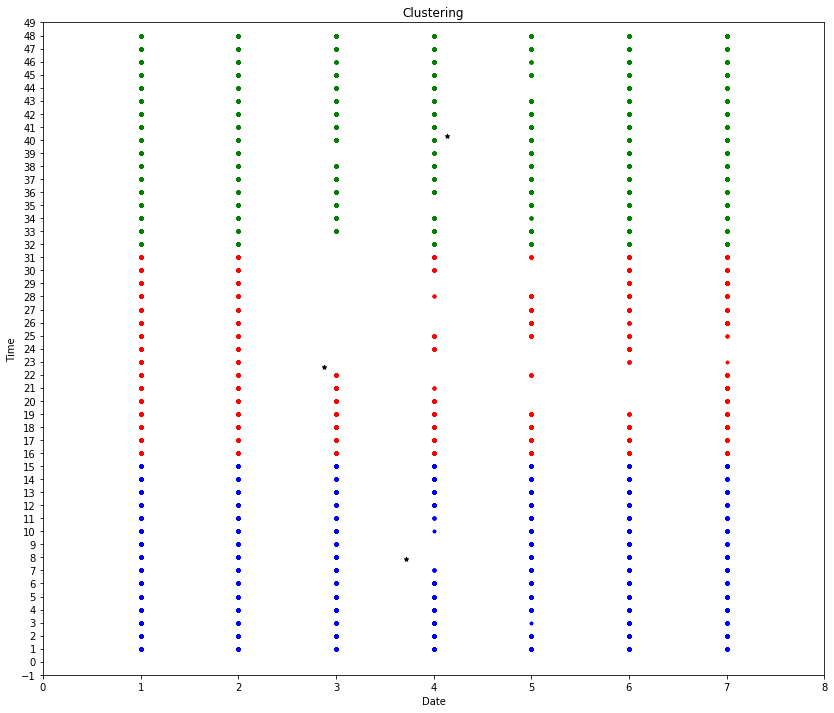

In [27]:
 #Plotting after clustering
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots(figsize=(14, 12))
plt.ylim([-1, 49])
plt.xlim([0, 8])
plt.xlabel("Date")
plt.ylabel("Time")
plt.title("Clustering")

tick_spacingx = 1
tick_spacingy = 1
ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacingx))
ax.yaxis.set_major_locator(plt.MultipleLocator(tick_spacingy))

for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
ax.scatter(C[:, 0], C[:, 1], marker='*', s=20, c='#050505')



In [28]:
#Final centroid cluster
print(C)

[[ 2.8832152 22.626028 ]
 [ 4.139671  40.303234 ]
 [ 3.7200043  7.8645535]]
